# Problem Set 3

### Import Packages

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
import pprint as pp
from skimage import data
import seaborn as sns

import sklearn
from sklearn.decomposition import PCA, TruncatedSVD, NMF

## Question 1

### 1) Load the CIFAR-10 dataset from (https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz). (Don’t upload the dataset to github.)

To avoid uploading the data to GitHub, the directory with all subsequent data files has been added to the .gitignore for my repo. 

The CIFAR-10 dataset, according to the README for this dataset (https://www.cs.toronto.edu/~kriz/cifar.html), consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images *which is approximately the 80-20 split requested for this assignment.* 

The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

The png files can be found here: https://www.kaggle.com/swaroopkml/cifar10-pngs-in-folders. 

In [2]:
# function to open pickled python files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### Meta Data

There are 10,000 cases per batch and 3072 values per visual.  
There are 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck

In [3]:
batches_meta = unpickle("data/cifar_10_batches_py/batches.meta")
print(batches_meta.keys())
print(batches_meta)

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])
{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}


### Explore Batch 1

There are four keys in each batch: 
- the batch label
- the labels corresponding to the image
- the 3072 array to define each image
- the filename.

In [4]:
batch_1 = unpickle("data/cifar_10_batches_py/data_batch_1")
print(len(batch_1))
print(batch_1.keys())

4
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [ ]:
pp.pprint(batch_1[b'batch_label'])

In [ ]:
pp.pprint(batch_1[b'labels'][:20]) # first 20 image labels

In [ ]:
pp.pprint(batch_1[b'data'][0]) # first image array
print("Dimension:", batch_1[b'data'][0].ndim)
print("Shape:", batch_1[b'data'][0].shape)
print("Filename:", batch_1[b'filenames'][0])

Let's view the training set's first image...

In [5]:
image1 = list(batch_1.values())[2][0] # extract first set of 3072 values

# divide array into 2D arrays for each color
# divide by 255 because max value for RGB scale
reds = np.reshape(image1[:1024],(32,32))/255
greens = np.reshape(image1[1024:2048],(32,32))/255
blues = np.reshape(image1[2048:],(32,32))/255

# create a 3D array
image1 = np.dstack((reds,greens,blues))
print("Dimension:", image1.ndim)
print("Shape:", image1.shape)

Dimension: 3
Shape: (32, 32, 3)


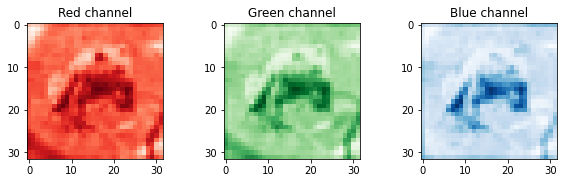

In [6]:
plt.figure(figsize=(10,2.5))
plt.subplot(131)
plt.gca().set_title('Red channel')
plt.imshow(reds, cmap='Reds', interpolation='nearest')
plt.subplot(132)
plt.gca().set_title('Green channel')
plt.imshow(greens, cmap='Greens', interpolation='nearest')
plt.subplot(133)
plt.gca().set_title('Blue channel')
plt.imshow(blues, cmap='Blues', interpolation='nearest')

plt.show()

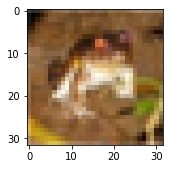

In [7]:
plt.figure(figsize=(2.5,2.5))
plt.imshow(image1, cmap=plt.cm.gray) 
plt.show()

Yay! After converting the arrayThis is an image of a frog.

**The above work helped me understand how the dataset was originally stored. At this point in my analysis, I noticed that the CIFAR-10 dataset could be accessed through Keras.** 

In [8]:
import tensorflow
import keras
from keras.datasets import cifar10

In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### 2)	Make an 80%-20% split on the dataset into test and train data.

In [10]:
# The training and testing data is approximately in a 80-20 split.
print('Traning data shape:', x_train.shape)
print('Testing data shape:', x_test.shape)

Traning data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)


In [ ]:
# corresponding training and testing labels
print('Traning labels shape:', y_train.shape)
print('Testing labels shape:', y_test.shape)

In [11]:
# unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of classes : ', nClasses)
print('Output classes : ', classes)

# from meta data above we know which numbers correspond to which image class
label_dict = {
 0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck',
}

Total number of classes :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


View example images from training and testing set.

Text(0.5, 1.0, 'cat')

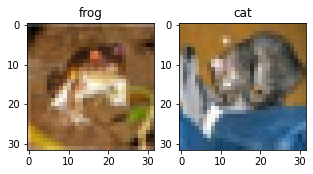

In [12]:
plt.figure(figsize=[5,5])

# Display the first image in training data (SAME AS ABOVE)
plt.subplot(121)
curr_img = np.reshape(x_train[0], (32,32,3))
plt.imshow(curr_img)
plt.title(str(label_dict[y_train[0][0]]))

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test[0],(32,32,3))
plt.imshow(curr_img)
plt.title(str(label_dict[y_test[0][0]]))

### 3)	Scale the data so that each feature has a minimum value of 0 and a maximum value of 1.

In [13]:
np.min(x_train),np.max(x_train) # current minimum and maximum

(0, 255)

In [14]:
x_train = x_train/255.0
print("New Minimum:" , np.min(x_train), "New Maximum:" , np.max(x_train))
print("Same Training Shape:" ,x_train.shape)

New Minimum: 0.0 New Maximum: 1.0
Same Training Shape: (50000, 32, 32, 3)


### 4)	Use the following dimensionality reduction techniques for feature extraction: (More in Question 3)
    a) Principal Component Analysis
    b) Singular Value Decomposition
    c) Non-negative Matrix Factorization
    
To begin, I will create a dataframe of pixel values for each image with their respective labels.

In [15]:
# reshape image dimensions from three to one
x_train_flat = x_train.reshape(-1,3072)

# name each column by pixel number
feat_cols = ['p'+str(i + 1) for i in range(x_train_flat.shape[1])]
df_cifar = pd.DataFrame(x_train_flat,columns=feat_cols)

# add image labels
df_cifar['label'] = y_train

# check dataframe shape
print('Size of the dataframe: {}'.format(df_cifar.shape))

Size of the dataframe: (50000, 3073)


In [16]:
df_cifar.head() # each row is image, each column contains pixel or label info

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p3064,p3065,p3066,p3067,p3068,p3069,p3070,p3071,p3072,label
0,0.231373,0.243137,0.247059,0.168627,0.180392,0.176471,0.196078,0.188235,0.168627,0.266667,...,0.847059,0.721569,0.549020,0.592157,0.462745,0.329412,0.482353,0.360784,0.282353,6
1,0.603922,0.694118,0.733333,0.494118,0.537255,0.533333,0.411765,0.407843,0.372549,0.400000,...,0.560784,0.521569,0.545098,0.560784,0.525490,0.556863,0.560784,0.521569,0.564706,9
2,1.000000,1.000000,1.000000,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.305882,0.333333,0.325490,0.309804,0.333333,0.325490,0.313725,0.337255,0.329412,9
3,0.109804,0.098039,0.039216,0.145098,0.133333,0.074510,0.149020,0.137255,0.078431,0.164706,...,0.211765,0.184314,0.109804,0.247059,0.219608,0.145098,0.282353,0.254902,0.180392,4
4,0.666667,0.705882,0.776471,0.658824,0.698039,0.768627,0.694118,0.725490,0.796078,0.717647,...,0.294118,0.309804,0.321569,0.278431,0.294118,0.305882,0.286275,0.301961,0.313725,1


#### a) Principal Component Analysis

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables that successively maximize variance.

In [104]:
pca = PCA(0.9) # want PCA model to capture 90% of variance

pca.fit(x_train_flat)
pca.n_components_ # need 99 components to acheive 90% variance explained

99

Therefore, to achieve 90% variance explained, use 99 principal components compared to the original 3072 pixels.

In [105]:
ncomp = 99
pca_cifar = PCA(n_components=ncomp)
principalComponents_cifar = pca_cifar.fit_transform(df_cifar.iloc[:,:-1])

# convert PC into dataframe
feat_cols = ['PC'+str(i + 1) for i in range(principalComponents_cifar.shape[1])]
principal_cifar_Df = pd.DataFrame(data = principalComponents_cifar, columns = feat_cols)
principal_cifar_Df['y'] = y_train
principal_cifar_Df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,y
0,-6.401018,2.729039,1.501711,-2.953333,-4.452582,0.647150,0.568989,0.092877,3.451771,1.168442,...,-0.624124,-0.247727,0.025060,0.251807,0.570299,-0.514198,-0.371723,-0.162250,-0.171248,6
1,0.829783,-0.949943,6.003753,1.504931,-1.368500,1.225687,0.606882,-0.523086,2.584150,2.565564,...,0.434617,-0.130904,-0.078812,-0.465871,-0.177158,-0.487108,0.645784,-0.510864,0.841024,9
2,7.730200,-11.522102,-2.753621,2.333595,-1.584409,-2.272213,-0.610438,-1.361358,-0.730908,-1.125914,...,-0.282559,-0.378789,-0.252362,-0.463868,-0.635227,0.588596,-0.691654,-0.258166,0.000109,9
3,-10.347817,0.010738,1.101019,-1.304540,-1.594870,0.867600,0.194107,0.232392,1.467262,-0.359152,...,0.116607,0.153153,0.134204,-0.082161,0.015394,0.259411,-0.146509,0.301764,-0.081440,4
4,-2.625651,-4.969240,1.034585,3.306459,1.261683,0.031241,5.655493,1.426761,3.918136,-1.955221,...,-0.648260,-0.771905,0.083278,0.077938,0.293044,-0.105892,0.391722,0.342218,-0.115849,1


In [106]:
print(pca_cifar.explained_variance_ratio_)
print('Total Variance Explained',sum(pca_cifar.explained_variance_ratio_))

[0.2907663  0.11253144 0.06694414 0.03676459 0.03608843 0.0280923
 0.02712992 0.02167162 0.02064641 0.01438001 0.01310563 0.01065978
 0.01049981 0.01004269 0.00918482 0.008174   0.00739608 0.0071613
 0.00687472 0.00643243 0.00594396 0.00587355 0.00495567 0.00490792
 0.00480452 0.00465877 0.00451348 0.00443654 0.00400781 0.00393866
 0.00366217 0.0033314  0.00323965 0.00310246 0.00307587 0.0029125
 0.00261219 0.00259261 0.00254345 0.00248378 0.00242671 0.0022932
 0.00228175 0.00221518 0.0021026  0.00206732 0.00192457 0.00190379
 0.0018466  0.00181696 0.00178052 0.001736   0.00171165 0.00169759
 0.00162334 0.0015859  0.00156412 0.001543   0.00153092 0.00149923
 0.00145784 0.00142323 0.00141115 0.00137705 0.00134851 0.00132664
 0.0012884  0.00124309 0.00121384 0.00121198 0.0011852  0.00116823
 0.00113992 0.0011229  0.00111661 0.00111007 0.00110271 0.00104805
 0.00103636 0.00101698 0.00099773 0.00098914 0.00097699 0.00097021
 0.00094263 0.00092804 0.00091944 0.00089571 0.00088368 0.00087098

#### b) Singular Value Decomposition

In linear algebra, the singular value decomposition is a factorization of a real or complex matrix. It generalizes the eigendecomposition of a square normal matrix with an orthonormal eigenbasis to any m\times n matrix.

In [72]:
# need 95 components to acheive at least 90% variance explained
svd = TruncatedSVD(n_components=95)

svd.fit(df_cifar)
print('Total Variance Explained',svd.explained_variance_ratio_.sum())

Total Variance Explained 0.9005406103175633


In [73]:
svd.singular_values_

array([6167.06941781, 1107.59770335,  871.0128406 ,  713.04883955,
        591.05083395,  583.20074447,  516.59774552,  506.24737248,
        454.29567094,  444.03129406,  370.00662877,  353.25084972,
        318.57753716,  316.3195339 ,  308.92840098,  295.64634661,
        278.9300634 ,  265.92216556,  260.23784057,  255.713316  ,
        247.45282514,  237.91151299,  236.55800359,  217.23864069,
        216.15737411,  213.19357275,  210.38411579,  207.28087905,
        205.51519939,  195.31756483,  193.62008765,  186.82961933,
        178.08573352,  175.61739404,  171.86196081,  171.10865055,
        166.51480734,  157.74673481,  157.10508955,  155.61335861,
        153.71662975,  151.99488675,  147.76882996,  147.38664815,
        145.21756276,  141.48051872,  140.29571959,  135.35657104,
        134.57316528,  132.58902688,  131.52000913,  130.18709395,
        128.5718687 ,  127.65046249,  126.97592391,  124.3113491 ,
        122.87204942,  122.0251342 ,  121.19633936,  120.71232

In [74]:
# apply SVD transform to dataset
transformed_svd = svd.fit_transform(df_cifar)
transformed_svd

array([[ 23.03239187,   5.88741159,  -3.90330135, ...,  -0.10342306,
         -0.20102066,   0.31588781],
       [ 29.35002361,   0.6053498 ,  -7.12279843, ...,   0.29574631,
         -0.25368471,  -0.10216136],
       [ 31.11657001, -13.13903221,  -1.32990045, ...,   0.1141766 ,
         -0.29500144,  -0.5904439 ],
       ...,
       [ 24.65663095, -10.61155073,  -3.98548617, ...,   0.05534365,
         -0.36869219,   0.12058405],
       [ 36.80488971,  -5.21104469,  -2.51692873, ...,  -0.47720961,
          0.31058184,   0.20927608],
       [ 28.81546294,  -2.89099756,   4.9008031 , ...,   0.05685937,
          0.59130374,   0.45637747]])

In [77]:
# convert SVD into dataframe
feat_cols = ['SVD'+str(i + 1) for i in range(transformed_svd.shape[1])]
svd_cifar_Df = pd.DataFrame(data = transformed, columns = feat_cols)
svd_cifar_Df['y'] = y_train
svd_cifar_Df.head()

,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10,...,SVD87,SVD88,SVD89,SVD90,SVD91,SVD92,SVD93,SVD94,SVD95,y
0,23.032392,5.887412,-3.903301,-3.911330,-1.451420,3.486323,-1.221588,-0.175539,0.105104,3.035011,...,-0.157610,-0.090423,0.158261,-0.583993,0.161092,0.588073,-0.103423,-0.201021,0.315888,6
1,29.350024,0.605350,-7.122798,-1.288804,2.566934,-1.080014,-2.207081,0.434003,-0.394384,1.695247,...,0.061926,-0.710921,-0.732957,-0.717964,-0.039251,-0.787567,0.295746,-0.253685,-0.102161,9
2,31.116570,-13.139032,-1.329900,-4.231005,3.011896,0.020637,1.983243,0.272471,-1.260196,-1.147925,...,-0.099869,-0.082400,-0.005191,-0.280226,-0.174618,0.184670,0.114177,-0.295001,-0.590444,9
3,17.708055,4.179032,-3.776211,-1.424109,-0.998337,1.921672,-0.722230,0.040444,0.149045,1.682877,...,0.016031,-0.123857,-0.347556,0.090438,0.021410,-0.020264,0.121047,0.185317,-0.243055,4
4,22.539212,-3.223153,-1.936590,2.999152,2.407146,-0.420751,-0.974675,-5.427899,1.080715,5.028589,...,0.001772,0.218596,-0.126146,0.423513,-0.452059,1.016662,-0.054958,-0.604905,-0.069268,1


#### c) Non-negative Matrix Factorization

Non-negative matrix factorization, also non-negative matrix approximation is a group of algorithms in multivariate analysis and linear algebra where a matrix V is factorized into two matrices W and H, with the property that all three matrices have no negative elements. 

In [107]:
nmf = NMF(n_components=100) # arbitrarily choose 100 components
trans_nmf = nmf.fit_transform(df_cifar)
print("Shape:", trans_nmf.shape)
feat_cols = ['NMF'+str(i + 1) for i in range(trans_nmf.shape[1])]
nmf_cifar_Df = pd.DataFrame(data = trans_nmf, columns = feat_cols)
nmf_cifar_Df['y'] = y_train
nmf_cifar_Df.head()

/Users/britneybrown/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Shape: (50000, 100)


,NMF1,NMF2,NMF3,NMF4,NMF5,NMF6,NMF7,NMF8,NMF9,NMF10,...,NMF92,NMF93,NMF94,NMF95,NMF96,NMF97,NMF98,NMF99,NMF100,y
0,0.000000,0.02102,0.119461,0.197335,0.157195,0.000000,0.010561,0.132890,0.063290,0.059516,...,0.016476,0.000000,0.024988,0.045351,0.042250,0.018335,0.034599,0.017581,0.088333,6
1,0.000000,0.00000,0.046748,0.297285,0.208795,0.054105,0.250949,0.167268,0.034434,0.019259,...,0.015226,0.033043,0.022151,0.068912,0.172298,0.092766,0.010168,0.000000,0.000000,9
2,0.168308,0.21039,0.021186,0.297530,0.000000,0.004269,0.089517,0.080588,0.270161,0.103308,...,0.096020,0.017213,0.025936,0.049460,0.166135,0.013993,0.062034,0.124289,0.000000,9
3,0.000000,0.00000,0.129835,0.131068,0.085608,0.000000,0.071446,0.074720,0.054939,0.000000,...,0.025373,0.015786,0.001919,0.039538,0.061202,0.025983,0.019243,0.016941,0.037870,4
4,0.000000,0.00000,0.052813,0.032568,0.000000,0.094172,0.216481,0.000000,0.111301,0.100173,...,0.025767,0.029656,0.027931,0.073297,0.038754,0.048184,0.000000,0.032505,0.000000,1


### 5)	Bonus: Provide some visualization on how these methods are different.

In [109]:
ncomp = 2

# PCA Example
pca_cifar_ex = PCA(n_components=ncomp)
principalComponents_cifar_ex = pca_cifar_ex.fit_transform(df_cifar.iloc[:,:-1])

principal_cifar_Df_ex = pd.DataFrame(data = principalComponents_cifar_ex
                    , columns = ['principal component 1', 'principal component 2'])
principal_cifar_Df_ex['y'] = y_train

# SVD Example
svd_ex = TruncatedSVD(n_components=ncomp)
svd_ex.fit(df_cifar)

svd_transform_ex = svd_ex.transform(df_cifar)
feat_cols = ['SVD'+str(i + 1) for i in range(svd_transform_ex.shape[1])]
svd_cifar_Df_ex = pd.DataFrame(data = svd_transform_ex, columns = feat_cols)
svd_cifar_Df_ex['y'] = y_train

# NMF Example
nmf_ex = NMF(n_components=ncomp)
trans_nmf_ex = nmf.fit_transform(df_cifar)

feat_cols = ['NMF'+str(i + 1) for i in range(trans_nmf_ex.shape[1])]
nmf_cifar_Df_ex = pd.DataFrame(data = trans_nmf_ex, columns = feat_cols)
nmf_cifar_Df_ex['y'] = y_train

/Users/britneybrown/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


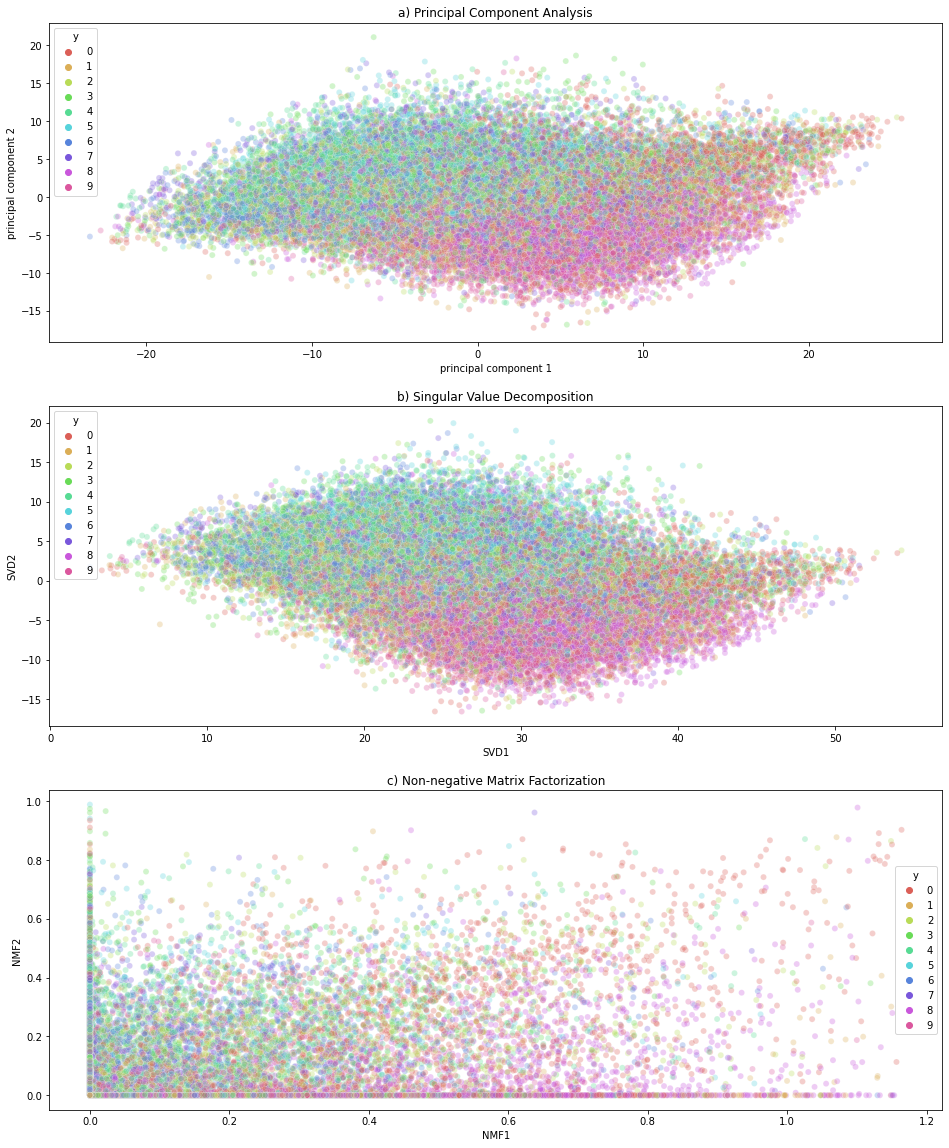

In [120]:
plt.figure(figsize=(16,20))

# PCA plot
plt.subplot(311)
plt.gca().set_title('a) Principal Component Analysis')
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=principal_cifar_Df_ex,
    legend="full",
    alpha=0.3
)

# SVD plot
plt.subplot(312)
plt.gca().set_title('b) Singular Value Decomposition')
sns.scatterplot(
    x="SVD1", y="SVD2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=svd_cifar_Df_ex,
    legend="full",
    alpha=0.3
)

# NMF plot
plt.subplot(313)
plt.gca().set_title('c) Non-negative Matrix Factorization')
sns.scatterplot(
    x="NMF1", y="NMF2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=nmf_cifar_Df_ex,
    legend="full",
    alpha=0.3
)

plt.savefig('images/question1.png')

In [ ]:
# prep testing data
x_test = x_test/255.0
x_test = x_test.reshape(-1,32,32,3)
x_test_flat = x_test.reshape(-1,3072)